In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/archive (1).zip'

# 압축 해제할 경로 입력
extraction_dir = '/content/dataset'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow.data as tfds

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [8]:
dir_path = "/content/dataset/UTKFace/"
image_paths = os.listdir(dir_path)

In [9]:
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}\n")

Total number of images  : 23708
Sample Image path       : 35_1_3_20170117154659552.jpg.chip.jpg
Sample Age              : 35



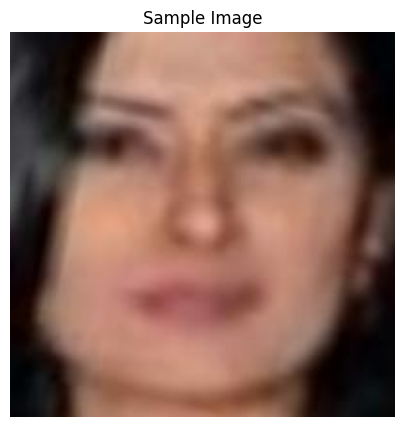

In [10]:
plt.figure(figsize=(5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [11]:
ages = []

for path in image_paths:
    age = int(path.split("_")[0])
    ages.append(age)


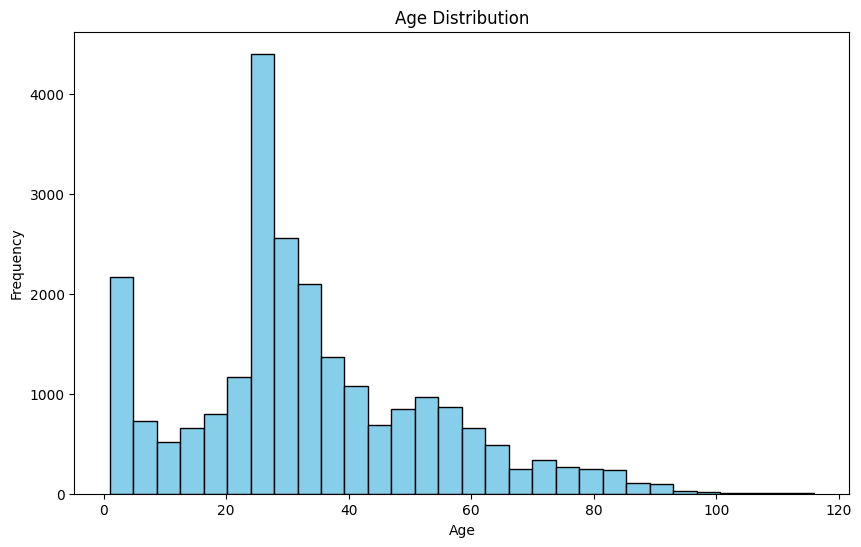

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [13]:
np.random.shuffle(image_paths)

train_images, test_images = train_test_split(image_paths, train_size=0.9, test_size=0.1)
train_images, valid_images = train_test_split(train_images, train_size=0.9, test_size=0.1)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")
print(f"Validation Size  : {len(valid_images)}")

Training Size : 19203
Testing Size  : 2371
Validation Size  : 2134


In [14]:
# Extract age
train_ages = [int(path.split("_")[0]) for path in train_images]
valid_ages = [int(path.split("_")[0]) for path in valid_images]
test_ages = [int(path.split("_")[0]) for path in test_images]

def preprocess_age_data(image_path, age, dir_path=dir_path, IMAGE_SIZE=IMAGE_SIZE):
    # Load and process the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0
    return image, age

In [15]:
# Tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_ages)).shuffle(2000)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_ages)).shuffle(2000)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_ages)).shuffle(500)

train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [16]:
# Model architecture
model = Sequential([
    ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False),
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='relu')
])

model.compile(optimizer=Adam(learning_rate=0.0003), loss='mae', metrics=['mae'])
model.summary()

# Training the model
history = model.fit(
    train_age_ds,
    validation_data=valid_age_ds,
    epochs=20,
    callbacks=[
        ModelCheckpoint('best_age_model.h5', save_best_only=True, monitor='val_loss')
    ]
)

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


601/601 [==============================] - 77s 68ms/step - loss: 7.7261 - mae: 7.7261 - val_loss: 21.3639 - val_mae: 21.3639
Epoch 2/20
601/601 [==============================] - 37s 62ms/step - loss: 6.1674 - mae: 6.1674 - val_loss: 6.2455 - val_mae: 6.2455
Epoch 3/20
601/601 [==============================] - 37s 62ms/step - loss: 5.5193 - mae: 5.5193 - val_loss: 5.5971 - val_mae: 5.5971
Epoch 4/20
601/601 [==============================] - 36s 60ms/step - loss: 5.0553 - mae: 5.0553 - val_loss: 5.7406 - val_mae: 5.7406
Epoch 5/20
601/601 [==============================] - 36s 60ms/step - loss: 4.6792 - mae: 4.6792 - val_loss: 6.0887 - val_mae: 6.0887
Epoch 6/20
601/601 [==============================] - 36s 60ms/step - loss: 4.3272 - mae: 4.3272 - val_loss: 6.0649 - val_mae: 6.0649
Epoch 7/20
601/601 [==============================] - 36s 60ms/step - loss: 4.0789 - mae: 4.0789 - val_loss: 6.1718 - val_mae: 6.1718
Epoch 8/20
601/601 [==============================] - 36s 60ms/step - l

1/1 [==============================] - 1s 983ms/step


<ipython-input-17-0b20854e2035>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Actual: {age}\nPredicted: {int(predictions[i])}")


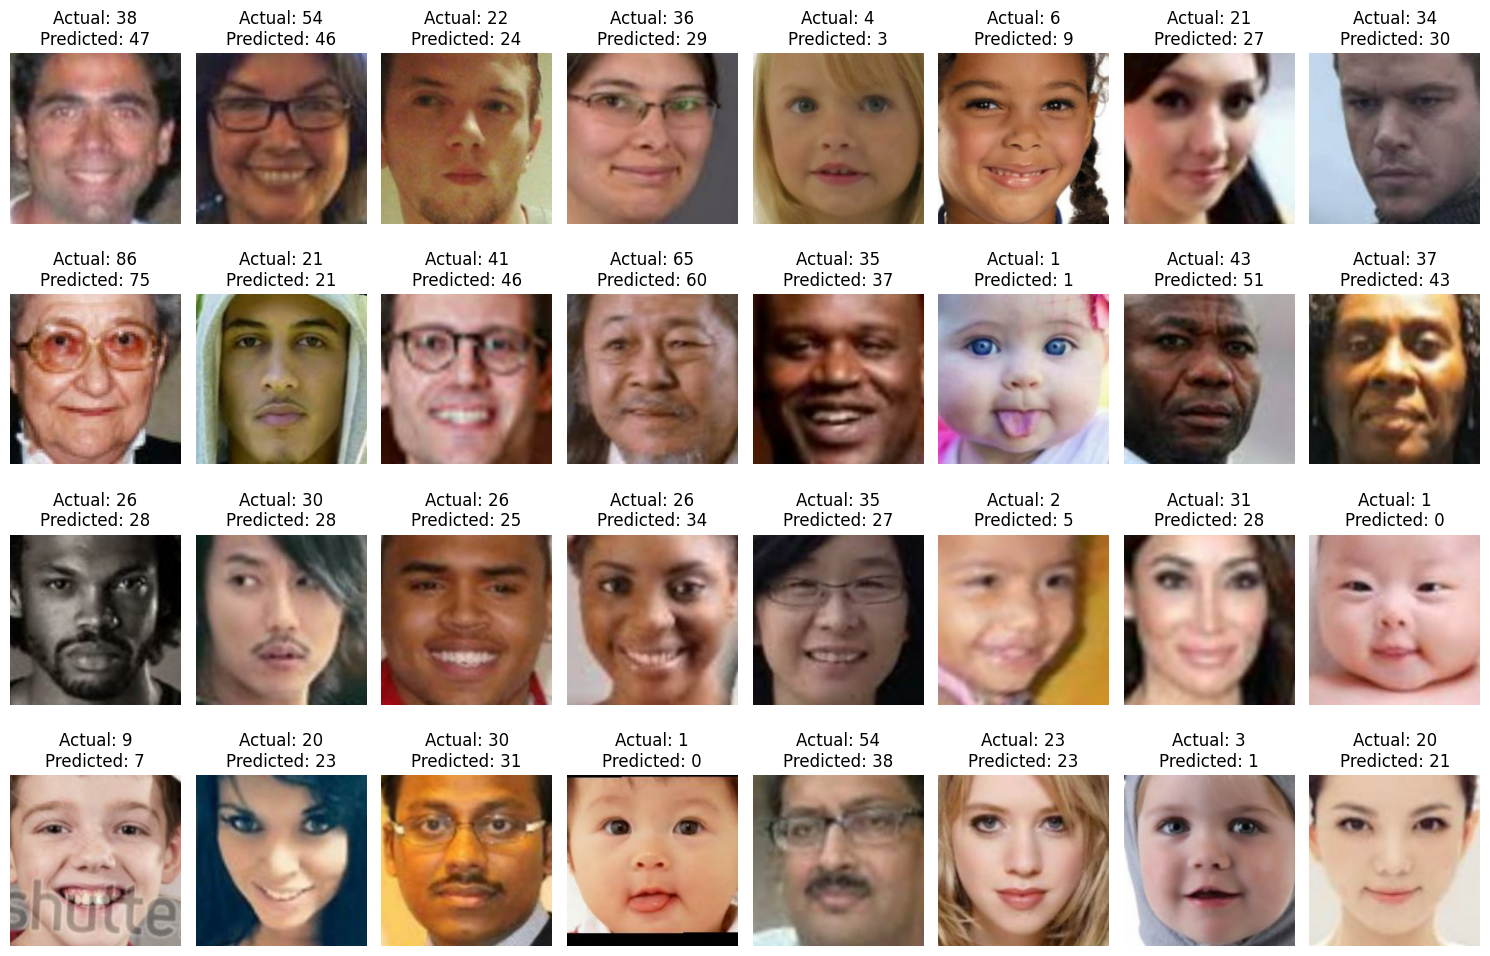

In [17]:
# Visualize predictions on the test set
plt.figure(figsize=(15, 10))
for images, ages in test_age_ds.take(1):
    predictions = model.predict(images)
    for i, (image, age) in enumerate(zip(images, ages)):
        plt.subplot(4, 8, i + 1)
        plt.imshow(image)
        plt.title(f"Actual: {age}\nPredicted: {int(predictions[i])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step
Predicted Age: 27.40


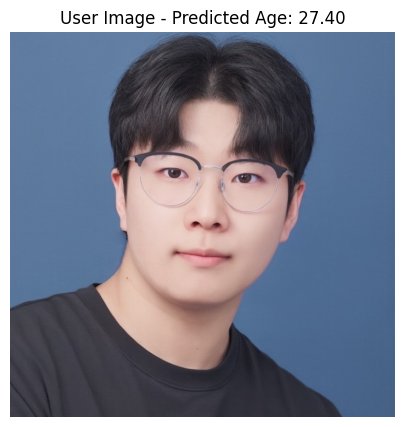

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf

def load_and_preprocess_image(image_path, image_size=IMAGE_SIZE):
    """이미지를 로드하고 전처리하는 함수"""
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0  # 정규화
    return image

def predict_age(model, image_path):
    """사용자의 사진으로 나이를 예측하는 함수"""
    image = load_and_preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)  # 모델 입력을 위해 배치 차원 추가
    predicted_age = model.predict(image)
    return predicted_age[0][0]

# 사용자의 이미지 경로
user_image_path = '/content/profile(1.1 crop).JPG'

# 이미지를 불러와 모델로 예측
predicted_age = predict_age(model, user_image_path)

# 결과 출력
print(f"Predicted Age: {predicted_age:.2f}")

# 이미지 표시
user_image = plt.imread(user_image_path)
plt.figure(figsize=(5, 5))
plt.imshow(user_image)
plt.title(f"User Image - Predicted Age: {predicted_age:.2f}")
plt.axis('off')
plt.show()
